In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import numpy as np
from lmfit import Model

In [6]:
def uq(ubar, Imax, q=0.90):
    I = Imax + np.log2(q)
    return ubar*((2**(2*I)- 1)/(2**(2*Imax) - 2**(2*I)))

Class Thick Ascending Limb: x_90 = 0.0005848505460513409, I_max = 0.6558995852940683, x_bar = 0.0002729041622808548
pixel 90 = 5.8040840321757265

Class Proximal Tubule Segments: x_90 = 0.0003826125350892307, I_max = 0.6626608408922592, x_bar = 0.0001769027539254425
pixel 90 = 4.694516164754328

Class Podocytes: x_90 = 0.0013217535550513397, I_max = 0.6944727105840708, x_bar = 0.0005865457211198031
pixel 90 = 8.725422899261511

Class Leukocytes: x_90 = 0.0006446777133175565, I_max = 0.6765678711771155, x_bar = 0.000292643487207254
pixel 90 = 6.093721054256689

Class Interstitial endothelial cells: x_90 = 0.000916345426278575, I_max = 0.7247539148604827, x_bar = 0.0003922590614342887
pixel 90 = 7.265087511767901

Class Glomerular endothelial cells: x_90 = 0.0005455631190955135, I_max = 0.7329371505972713, x_bar = 0.0002313855225189085
pixel 90 = 5.605750231672972

Class Distal Convoluted Tubule: x_90 = 0.0005415340083171266, I_max = 0.5309017646578318, x_bar = 0.0003108811818176746
pixe

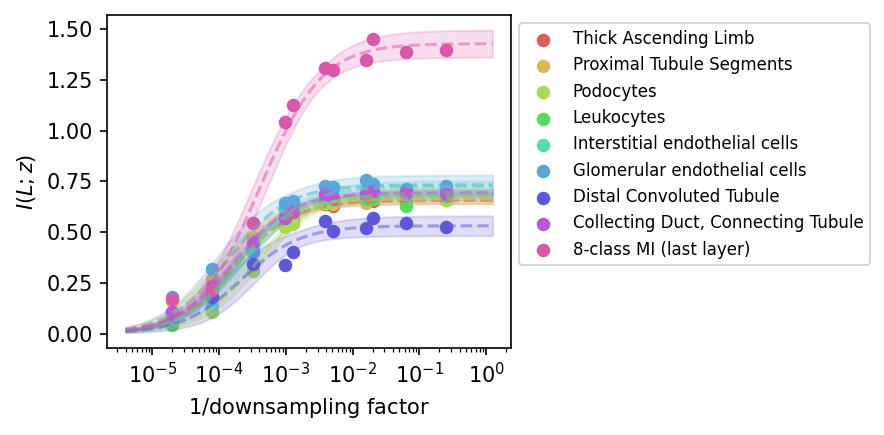

Class Thick Ascending Limb: x_90 = 0.6664780479330747, I_max = 0.6521494241679634, x_bar = 0.3126053059596352

Class Proximal Tubule Segments: x_90 = 0.4494986912937183, I_max = 0.6652627898456365, x_bar = 0.20710375660138902

Class Podocytes: x_90 = 1.4337113206805006, I_max = 0.7148986643053682, x_bar = 0.6207716919277425

Class Leukocytes: x_90 = 0.4927092819459463, I_max = 0.6844667248620818, x_bar = 0.22140433775463156

Class Interstitial endothelial cells: x_90 = 0.7263597264440533, I_max = 0.750354120902113, x_bar = 0.3022388598866138

Class Glomerular endothelial cells: x_90 = 0.3481910649705034, I_max = 0.7457176823609706, x_bar = 0.14560920686089593

Class Distal Convoluted Tubule: x_90 = 1.1015378771336024, I_max = 0.5604456199154433, x_bar = 0.5976527273915546

Class Collecting Duct, Connecting Tubule: x_90 = 0.5101932957921295, I_max = 0.7003160977664125, x_bar = 0.2247876581024574

Class 8-class MI (last layer): x_90 = 5.5299755787075, I_max = 1.5074969620546543, x_bar = 

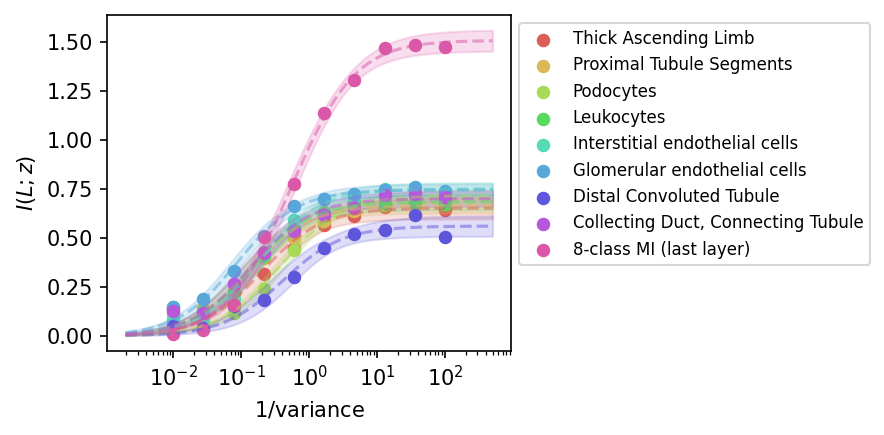

In [10]:
# Get all result CSV files
csv_files = glob.glob('images/tissuemnist_models/result_*.csv')

# Load and combine all CSVs
dfs = []
for file in csv_files:
    match = re.search(r'result_(.+)\.csv', file)
    

    downsampling_type = 'unknown'

    if match.group(1) == 'clean':
        downsampling_type = 'clean'
        downsampling_level = 0.0

    elif 'pix' in match.group(1):
        downsampling_type = 'pixel'
        downsampling_level = float(str(match.group(1).split('_')[1])[:-1])

    elif 'gauss' in match.group(1):
        downsampling_type = 'gaussian'
        downsampling_level = float(str(match.group(1).split('_')[1])[:-1])

    
    # Read CSV and add downsampling column
    df = pd.read_csv(file)
    df['downsampling_level'] = downsampling_level
    df['downsampling_type'] = downsampling_type
    dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)


def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B + 1)/(1 + A*(x)))

# Prepare data for pixel downsampling
pix = combined_df[combined_df['downsampling_type'] == 'pixel'].copy()
pix['inv_factor'] = 1 / pix['downsampling_level']

# Get OVA MI columns
ova_columns = ['mi_score'] + [col for col in pix.columns if col.startswith('ova_mi_continuous_Class_')]
n_classes = len(ova_columns)

label_map = {
    'ova_mi_continuous_Class_0': 'Collecting Duct, Connecting Tubule',
    'ova_mi_continuous_Class_1': 'Distal Convoluted Tubule',
    'ova_mi_continuous_Class_2': 'Glomerular endothelial cells',
    'ova_mi_continuous_Class_3': 'Interstitial endothelial cells',
    'ova_mi_continuous_Class_4': 'Leukocytes',
    'ova_mi_continuous_Class_5': 'Podocytes',
    'ova_mi_continuous_Class_6': 'Proximal Tubule Segments',
    'ova_mi_continuous_Class_7': 'Thick Ascending Limb',
    'mi_score': '8-class MI (last layer)',
    'discrete_mi': '8-class MI (predicted label)'
}

# Create figure
fig = plt.figure(figsize=(6, 3), dpi=150)

# Generate color palette
palette = sns.color_palette("hls", n_classes)

# Fit and plot each class
for i, col in enumerate(ova_columns[::-1]):
    # Prepare data (remove any NaN values)
    mask = ~pix[col].isna() & ~pix['inv_factor'].isna()
    x_data = pix[mask]['inv_factor'].values**2
    y_data = pix[mask][col].values
    

    # Create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e3, B=1e3)
    params['A'].min = 0
    params['B'].min = 0
    
    try:
        # Fit model
        result = model.fit(y_data, params, x=x_data)
        # print(result.params)
        
        # Generate fit line
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
        y_fit = model.eval(params=result.params, x=x_fit)
        
        # Calculate confidence bands
        y_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_lower = -y_upper
        
        # Plot fit
        plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
        plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                        color=palette[i], alpha=0.2)

        x_bar = 1/result.params['A'].value
        I_max = 0.5*np.log2(result.params['B'].value/result.params['A'].value)

        x_90 = uq(x_bar, I_max, q=0.90)
        pixel_90 = np.sqrt(x_90*240*240)
        print(f'Class {label_map.get(col, col)}: x_90 = {x_90}, I_max = {I_max}, x_bar = {x_bar}')
        print(f'pixel 90 = {pixel_90}')
        print()

    except:
        pass  # Skip if fit fails
    
    # Plot data
    plt.scatter(x_data, y_data, color=palette[i], 
               label=label_map.get(col, col), s=30)

plt.xlabel(r'$1/\text{downsampling factor}$')
plt.ylabel(r'$I(L; z)$')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B + 1)/(1 + A*(x)))

# Prepare data for gaussian downsampling
gauss = combined_df[combined_df['downsampling_type'] == 'gaussian'].copy()

# Create figure
fig = plt.figure(figsize=(6, 3), dpi=150)

# Generate color palette
palette = sns.color_palette("hls", n_classes)

# Fit and plot each class
for i, col in enumerate(ova_columns[::-1]):
    # Prepare data (remove any NaN values)
    mask = ~gauss[col].isna()
    x_data = 1/gauss[mask]['downsampling_level'].values
    y_data = gauss[mask][col].values
    

    # Create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-3, B=1e-3)
    params['A'].min = 0
    params['B'].min = 0
    
    try:
        # Fit model
        result = model.fit(y_data, params, x=x_data)
        # print(result.params)
        
        # Generate fit line
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
        y_fit = model.eval(params=result.params, x=x_fit)
        
        # Calculate confidence bands
        y_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_lower = -y_upper
        
        # Plot fit
        plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
        plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                        color=palette[i], alpha=0.2)
        x_bar = 1/result.params['A'].value
        I_max = 0.5*np.log2(result.params['B'].value/result.params['A'].value)

        x_90 = uq(x_bar, I_max, q=0.90)
        print(f'Class {label_map.get(col, col)}: x_90 = {x_90}, I_max = {I_max}, x_bar = {x_bar}')
        print()
    except:
        pass  # Skip if fit fails
    
    # Plot data
    plt.scatter(x_data, y_data, color=palette[i], 
               label=label_map.get(col, col), s=30)

plt.xlabel(r'$1/\text{variance}$')
plt.ylabel(r'$I(L; z)$')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

Parameters([('A', <Parameter 'A', value=0.5586934249666098 +/- 0.215, bounds=[0:inf]>), ('B', <Parameter 'B', value=0.9090586675393189 +/- 0.328, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=0.5134143857040236 +/- 0.122, bounds=[0:inf]>), ('B', <Parameter 'B', value=0.9502342980959568 +/- 0.209, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=0.8176461055251563 +/- 0.209, bounds=[0:inf]>), ('B', <Parameter 'B', value=1.1750358117945865 +/- 0.288, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1.1176375255192754 +/- 0.249, bounds=[0:inf]>), ('B', <Parameter 'B', value=1.8052335846073655 +/- 0.382, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1.5970273674789315 +/- 0.471, bounds=[0:inf]>), ('B', <Parameter 'B', value=2.776312236498925 +/- 0.774, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=0.9777667766075688 +/- 0.493, bounds=[0:inf]>), ('B', <Parameter 'B', value=1.434520638581533 +/- 0.692, bounds=[0:inf]>)])
Parameters([

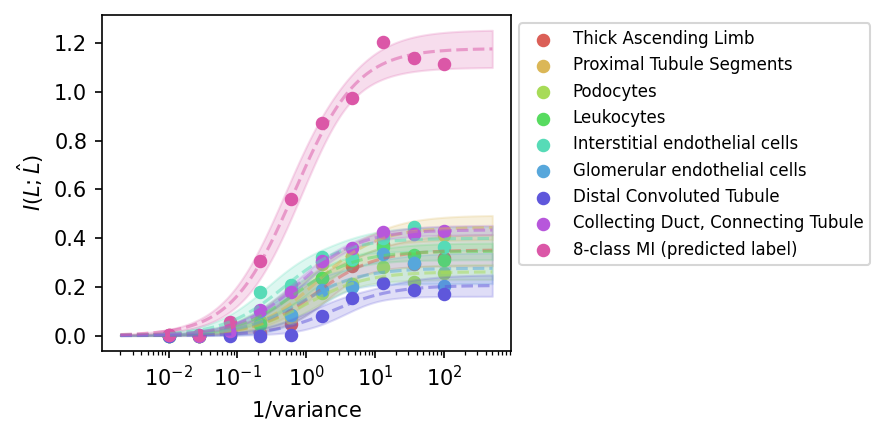

In [ ]:
def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B + 1)/(1 + A*(x)))

# Prepare data for gaussian downsampling
gauss = combined_df[combined_df['downsampling_type'] == 'gaussian'].copy()

# Get OVA MI columns
ova_columns = ['discrete_mi'] + [col for col in gauss.columns if col.startswith('ova_mi_Class_')]
n_classes = len(ova_columns)

label_map = {
    'ova_mi_Class_0': 'Collecting Duct, Connecting Tubule',
    'ova_mi_Class_1': 'Distal Convoluted Tubule',
    'ova_mi_Class_2': 'Glomerular endothelial cells',
    'ova_mi_Class_3': 'Interstitial endothelial cells',
    'ova_mi_Class_4'15 pixels: images downsampled beyond this point lose more than 0.5 bits of label information.: 'Leukocytes',
    'ova_mi_Class_5': 'Podocytes',
    'ova_mi_Class_6': 'Proximal Tubule Segments',
    'ova_mi_Class_7': 'Thick Ascending Limb',
    'mi_score': '8-class MI (last layer)',
    'discrete_mi': '8-class MI (predicted label)'
}

# Create figure
fig = plt.figure(figsize=(6, 3), dpi=150)

# Generate color palette
palette = sns.color_palette("hls", n_classes)

# Fit and plot each class
for i, col in enumerate(ova_columns[::-1]):
    # Prepare data (remove any NaN values)
    mask = ~gauss[col].isna()
    x_data = 1/gauss[mask]['downsampling_level'].values
    y_data = gauss[mask][col].values
    

    # Create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-3, B=1e-3)
    params['A'].min = 0
    params['B'].min = 0
    
    try:
        # Fit model
        result = model.fit(y_data, params, x=x_data)
        print(result.params)
        
        # Generate fit line
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
        y_fit = model.eval(params=result.params, x=x_fit)
        
        # Calculate confidence bands
        y_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_lower = -y_upper
        
        # Plot fit
        plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
        plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                        color=palette[i], alpha=0.2)
    except:
        pass  # Skip if fit fails
    
    # Plot data
    plt.scatter(x_data, y_data, color=palette[i], 
               label=label_map.get(col, col), s=30)

plt.xlabel(r'$1/\text{variance}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

Parameters([('A', <Parameter 'A', value=1246.720509862656 +/- 219, bounds=[0:inf]>), ('B', <Parameter 'B', value=1945.7294338433524 +/- 326, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1981.1564609460115 +/- 495, bounds=[0:inf]>), ('B', <Parameter 'B', value=3352.7509158874086 +/- 800, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=571.8184869037709 +/- 215, bounds=[0:inf]>), ('B', <Parameter 'B', value=858.4258227596526 +/- 307, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1086.0704195548774 +/- 473, bounds=[0:inf]>), ('B', <Parameter 'B', value=1549.5277092752135 +/- 649, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1504.4521780833463 +/- 446, bounds=[0:inf]>), ('B', <Parameter 'B', value=2468.212463705764 +/- 698, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', value=1217.4559267616214 +/- 534, bounds=[0:inf]>), ('B', <Parameter 'B', value=1743.5299482437877 +/- 736, bounds=[0:inf]>)])
Parameters([('A', <Parameter 'A', valu

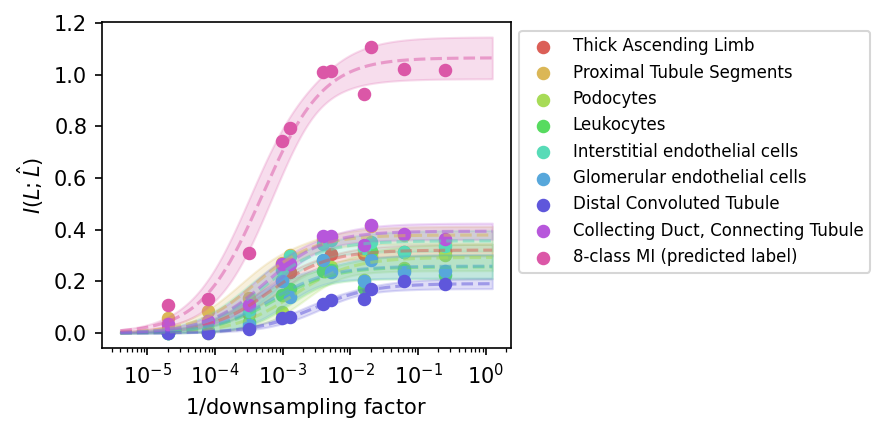

In [4]:
def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B + 1)/(1 + A*(x)))

# Prepare data for pixel downsampling
pix = combined_df[combined_df['downsampling_type'] == 'pixel'].copy()
pix['inv_factor'] = 1 / pix['downsampling_level']

# Create figure
fig = plt.figure(figsize=(6, 3), dpi=150)

# Generate color palette
palette = sns.color_palette("hls", n_classes)

# Fit and plot each class
for i, col in enumerate(ova_columns[::-1]):
    # Prepare data (remove any NaN values)
    mask = ~pix[col].isna() & ~pix['inv_factor'].isna()
    x_data = pix[mask]['inv_factor'].values**2
    y_data = pix[mask][col].values
    

    # Create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e3, B=1e3)
    params['A'].min = 0
    params['B'].min = 0
    
    try:
        # Fit model
        result = model.fit(y_data, params, x=x_data)
        print(result.params)
        
        # Generate fit line
        x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
        y_fit = model.eval(params=result.params, x=x_fit)
        
        # Calculate confidence bands
        y_upper = result.eval_uncertainty(params=result.params, x=x_fit, sigma=2)
        y_lower = -y_upper
        
        # Plot fit
        plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
        plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                        color=palette[i], alpha=0.2)
    except:
        pass  # Skip if fit fails
    
    # Plot data
    plt.scatter(x_data, y_data, color=palette[i], 
               label=label_map.get(col, col), s=30)

plt.xlabel(r'$1/\text{downsampling factor}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()